# 0.0 Imports

In [83]:
import joblib
import requests
import inflection

import numpy   as np
import pandas  as pd
import seaborn as sns

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt

from boruta                import BorutaPy

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics         import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

from xgboost               import XGBClassifier
from sklearn.dummy         import DummyClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.linear_model  import LogisticRegression

## 0.1 Helper Functions

In [84]:
def ml_error(model_name, y, y_pred):
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    return pd.DataFrame({
        'Accuracy': accuracy, 
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    },
        index=[model_name])

In [85]:
accuracy = make_scorer(accuracy_score)
precision = make_scorer(lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro"))
recall = make_scorer(lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro"))
f1 = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"))

In [86]:
def ml_cv_results(model_name, model, rescaler, X, y):

    X_ = X.to_numpy()
    y_ = y.to_numpy()

    mm = rescaler
    
    accuracies = []
    precisions = []
    recalls = []
    f1s = []

    '''for for cross validation'''
    kf = KFold(n_splits=5, shuffle=True)
    for train, test in kf.split(X_):
       
        X_train, X_test = X_[train], X_[test]
        y_train, y_test = y_[train], y_[test]

        X_train_rescaled = X_train.copy()
        X_test_rescaled = X_test.copy()
        
        X_train_rescaled = mm.fit_transform(X_train)
        X_test_rescaled = mm.fit_transform(X_test)
        
        model.fit(X_train_rescaled, y_train)
        y_pred = model.predict(X_test_rescaled)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average="macro"))
        recalls.append(recall_score(y_test, y_pred, average="macro"))
        f1s.append(f1_score(y_test, y_pred, average="macro"))
        
    accuracy_mean, accuracy_std = np.round(np.mean(accuracies), 3), np.round(np.std(accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    
    return pd.DataFrame({"Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +- {}".format(precision_mean, precision_std),
                        "Recall": "{} +- {}".format(recall_mean, recall_std),
                        "F1": "{} +- {}".format(f1_mean, f1_std)},
                       index=[model_name])

In [87]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr-1, rcorr-1)))

In [88]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    else:
        life_stage = "Late Adulthood"
        
    return life_stage

In [89]:
def catIBM(ibm):
    if ibm < 18.5:
        status = "Underweight"
    
    elif ibm >= 18.5 and ibm <= 24.9:
        status = "Healthy"
    
    elif ibm >= 25.0 and ibm <= 29.9:
        status = "Overweight"
        
    elif ibm >= 30.0:
        status = "Obese"
        
    return status

In [90]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [91]:
jupyter_settings()

In [92]:
np.random.seed(42)

## 0.2 Loading Data

In [93]:
df_raw = pd.read_csv('../databases/diabetes.csv')

# 1.0 Data Descripton

In [94]:
df1 = df_raw.copy()

## 1.1 About Columns

* Pregnancies - Number of times pregnant
* Glucose - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure - Diastolic blood pressure (mm Hg)
* SkinThickness - Triceps skin fold thickness (mm)
* Insulin - 2-Hour serum insulin (mu U/ml)
* BMI - Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction - Diabetes pedigree function
* Age - Age (years)
* Outcome - Class variable (0 or 1) 268 of 768 are 1, the others are 0

## 1.2 Rename Columns

In [95]:
cols_old = df1.columns.to_list()

snakecase = lambda i: inflection.underscore(i)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.3 Data Dimensions

In [96]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 768
Number of Cols: 9


## 1.4 Data Types

In [97]:
df1.dtypes

pregnancies                     int64
glucose                         int64
blood_pressure                  int64
skin_thickness                  int64
insulin                         int64
bmi                           float64
diabetes_pedigree_function    float64
age                             int64
outcome                         int64
dtype: object

## 1.5 Check NA

In [98]:
df1.isna().mean()

pregnancies                   0.0
glucose                       0.0
blood_pressure                0.0
skin_thickness                0.0
insulin                       0.0
bmi                           0.0
diabetes_pedigree_function    0.0
age                           0.0
outcome                       0.0
dtype: float64

## 1.6 Change Data Types

In [99]:
df1["outcome"] = df1["outcome"].map({0: "No", 1: "Yes"})
df1.dtypes

pregnancies                     int64
glucose                         int64
blood_pressure                  int64
skin_thickness                  int64
insulin                         int64
bmi                           float64
diabetes_pedigree_function    float64
age                             int64
outcome                        object
dtype: object

## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [100]:
df1.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### 1.7.2 Categorical Attributes

In [101]:
df1.outcome.value_counts()

No     500
Yes    268
Name: outcome, dtype: int64

# 2.0 Feature Engineering

In [102]:
df2 = df1.copy()

## 2.1 Mind Map

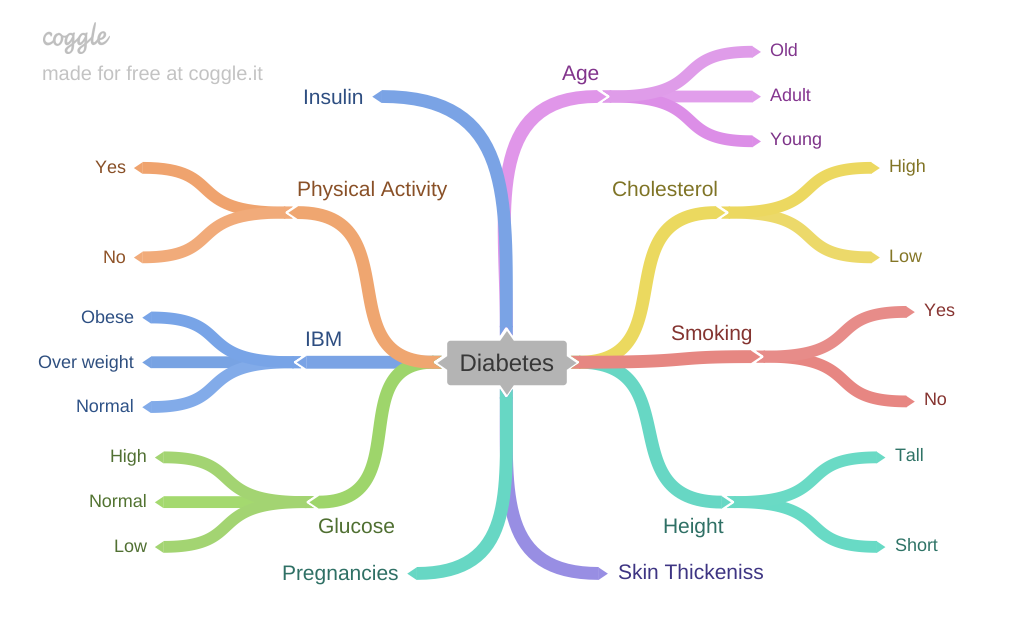

In [103]:
Image('../images/diabetes-mind-map.png')

## 2.2 Creating Hypotheses

1. There's more probability to a adult or old peaple be diabetic.

1. those who do physical activity are less likely to be diabetic.

1. People with thicker skin are more likely to be diabetic.

1. The greater the number of pregnancies, the more likely the person is to be diabetic.

1. Obese and over weight people are more likely to be diabetic.

1. Non-smoking people are less likely to be diabetic.

1. Peaple with high insuline more likely to be non-diabetic.

1. Peaple with high glucose more likely to be diabetic.

## 2.3 Feature Enginering

In [104]:
df2['life_stage'] = df2['age'].apply(getLifeStage)
df2['weight_status'] = df2['bmi'].apply(catIBM)

In [105]:
df2.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome,life_stage,weight_status
0,6,148,72,35,0,33.6,0.627,50,Yes,Midlife,Obese
1,1,85,66,29,0,26.6,0.351,31,No,Early Adulthood,Overweight
2,8,183,64,0,0,23.3,0.672,32,Yes,Early Adulthood,Healthy
3,1,89,66,23,94,28.1,0.167,21,No,Early Adulthood,Overweight
4,0,137,40,35,168,43.1,2.288,33,Yes,Early Adulthood,Obese


# 3.0 Filtering Variables

In [106]:
df3 = df2.copy()

## 3.1 Filtering Columns

In this CRISP cicle I won't drop columns.

## 3.2 Filtering Rows

I won't exclude any rows in this CRISP cycle.

# 4.0 Exploratory Data Analysis

In [107]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

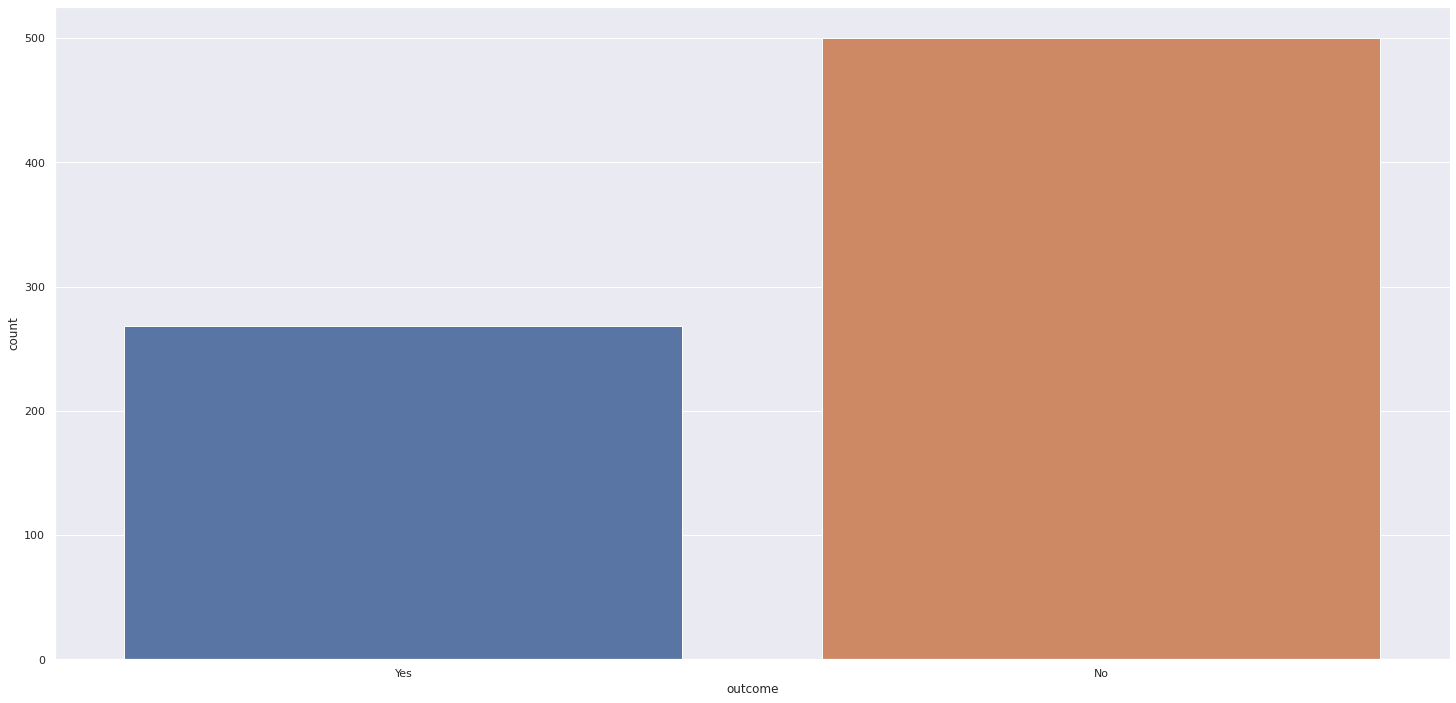

In [108]:
sns.countplot(x='outcome', data=df4);

### 4.1.2 Numerical Variables

In [109]:
num_attr = df4.select_dtypes(exclude='object')

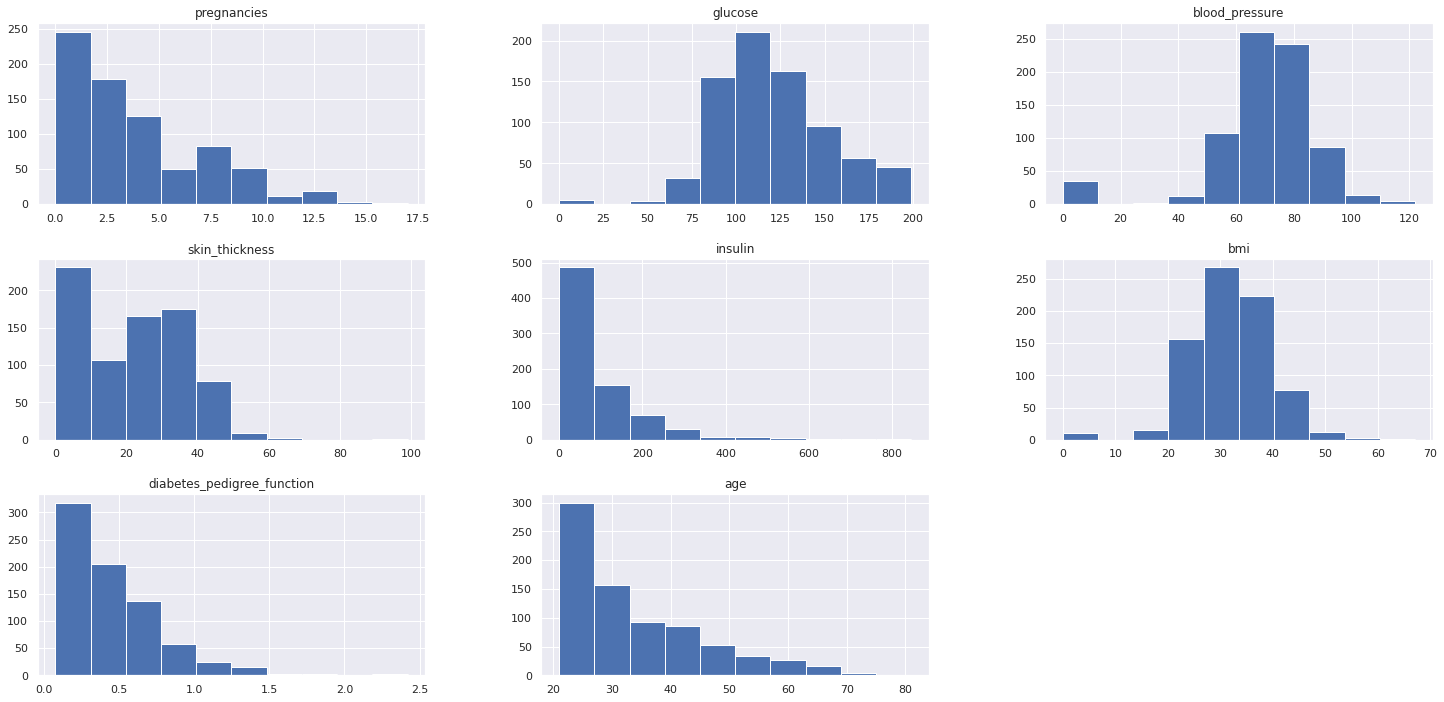

In [110]:
num_attr.hist();

### 4.1.3 Categorical Variables

In [111]:
cat_attr = df4.select_dtypes(include='object')

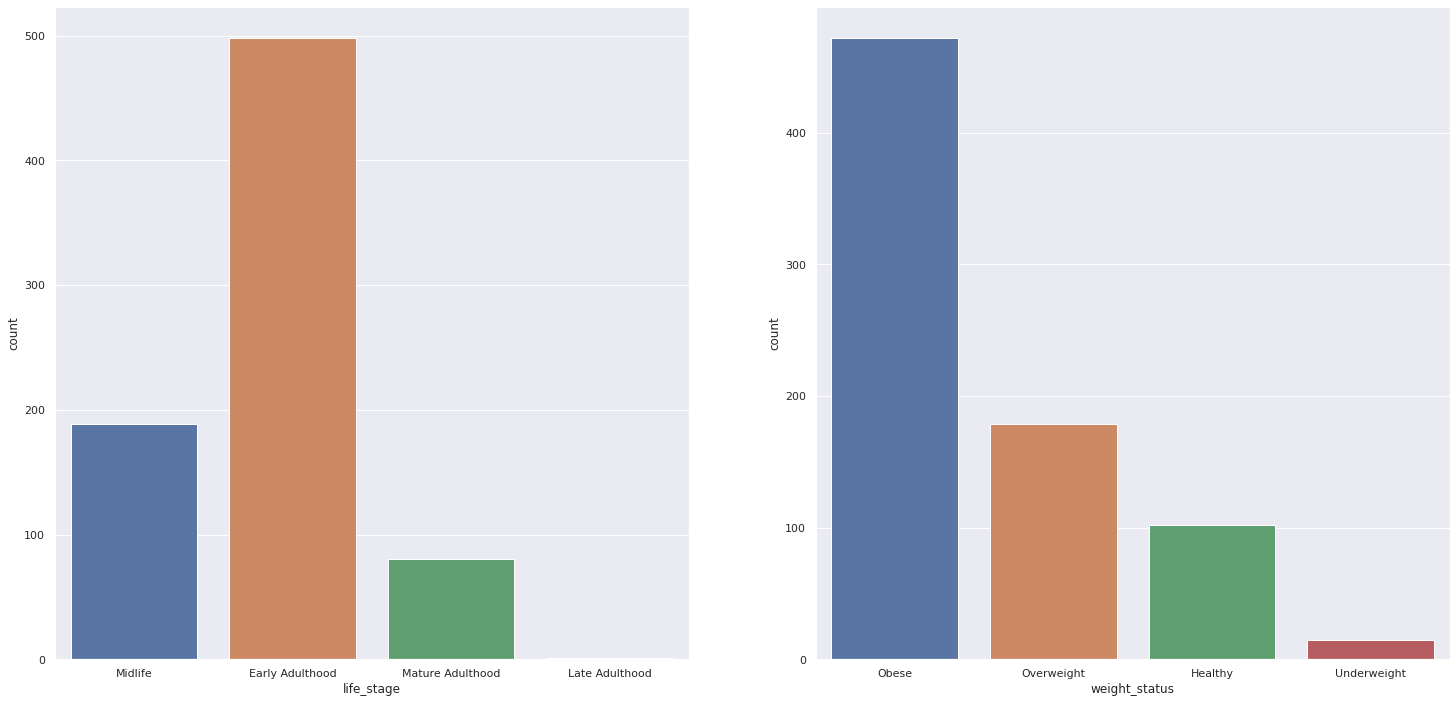

In [112]:
plt.subplot(1, 2, 1)
sns.countplot(x='life_stage', data=cat_attr);

plt.subplot(1, 2, 2)
sns.countplot(x='weight_status', data=cat_attr);

## 4.2 Bivariate Analysis

### H1 There's more probability to a adult or old peaple be diabetic.
**FALSE** There's no more adult or old peaple diabetic. 

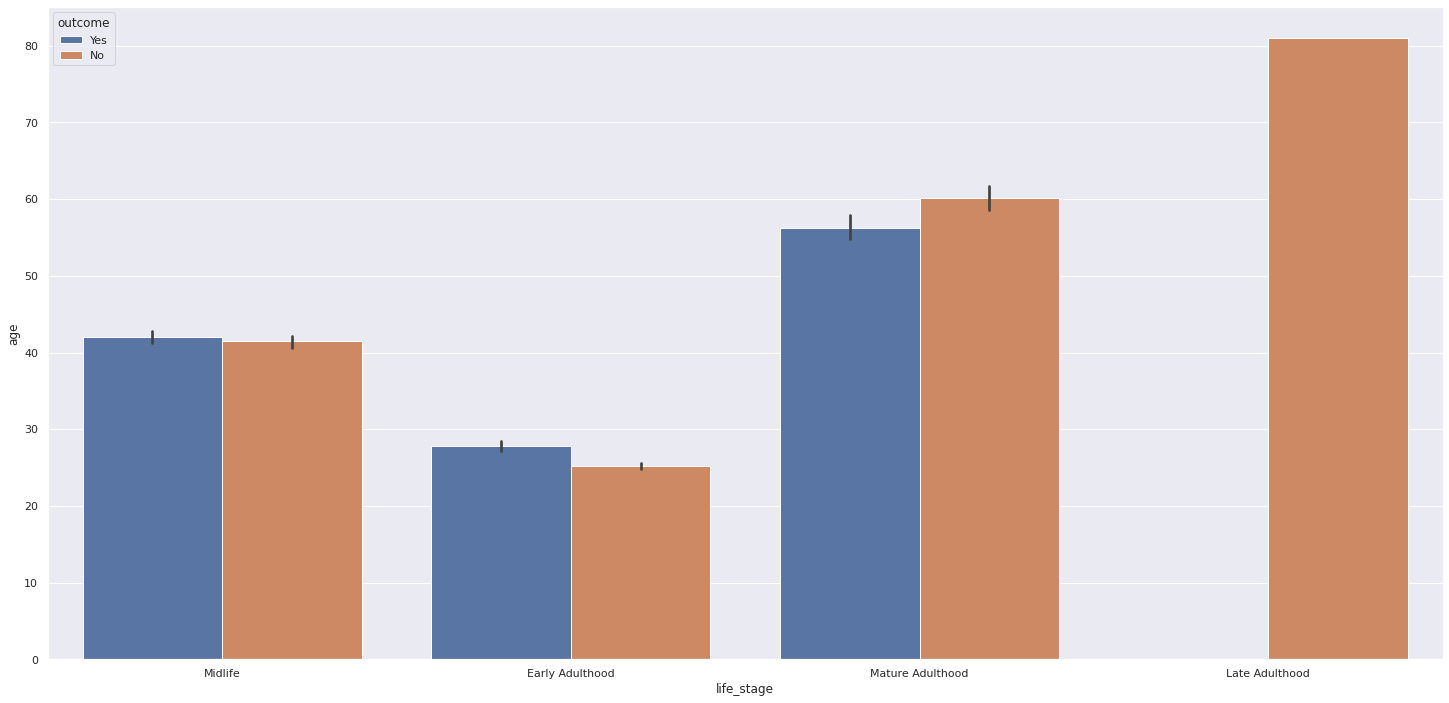

In [113]:
sns.barplot(y='age', hue='outcome', x='life_stage', data=df4);

### H2 Those who do physical activity are less likely to be diabetic.

**INCONCLUSIVE** There's no data about peaple's physical activity.

### H3 People with thicker skin are more likely to be diabetic.

**TRUE** Peaple with non-thicker skin are more likely to be diabetic.

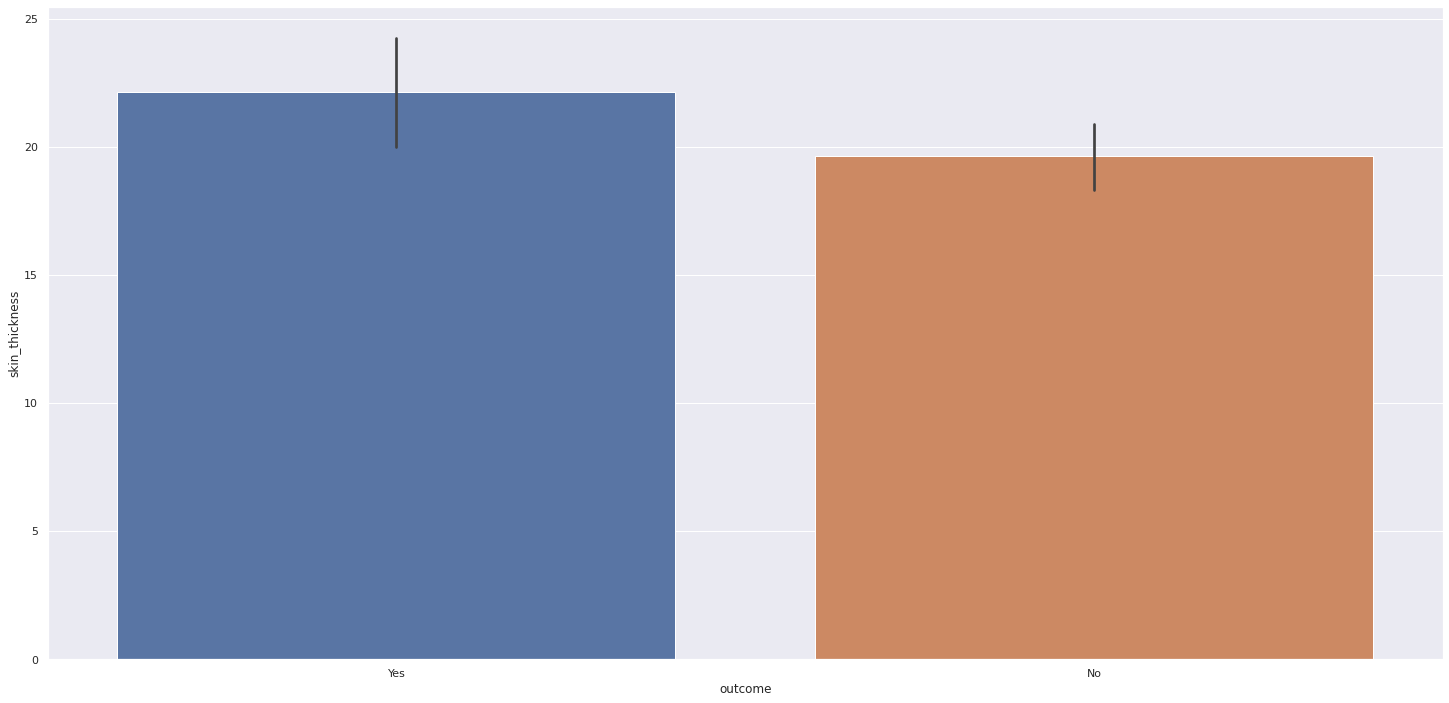

In [114]:
sns.barplot(y='skin_thickness', x='outcome', data=df4);

### H4 The greater the number of pregnancies, the more likely the person is to be diabetic.
**TRUE** Peaple with a greater number of pregnancies there's more probability to be diabetic.

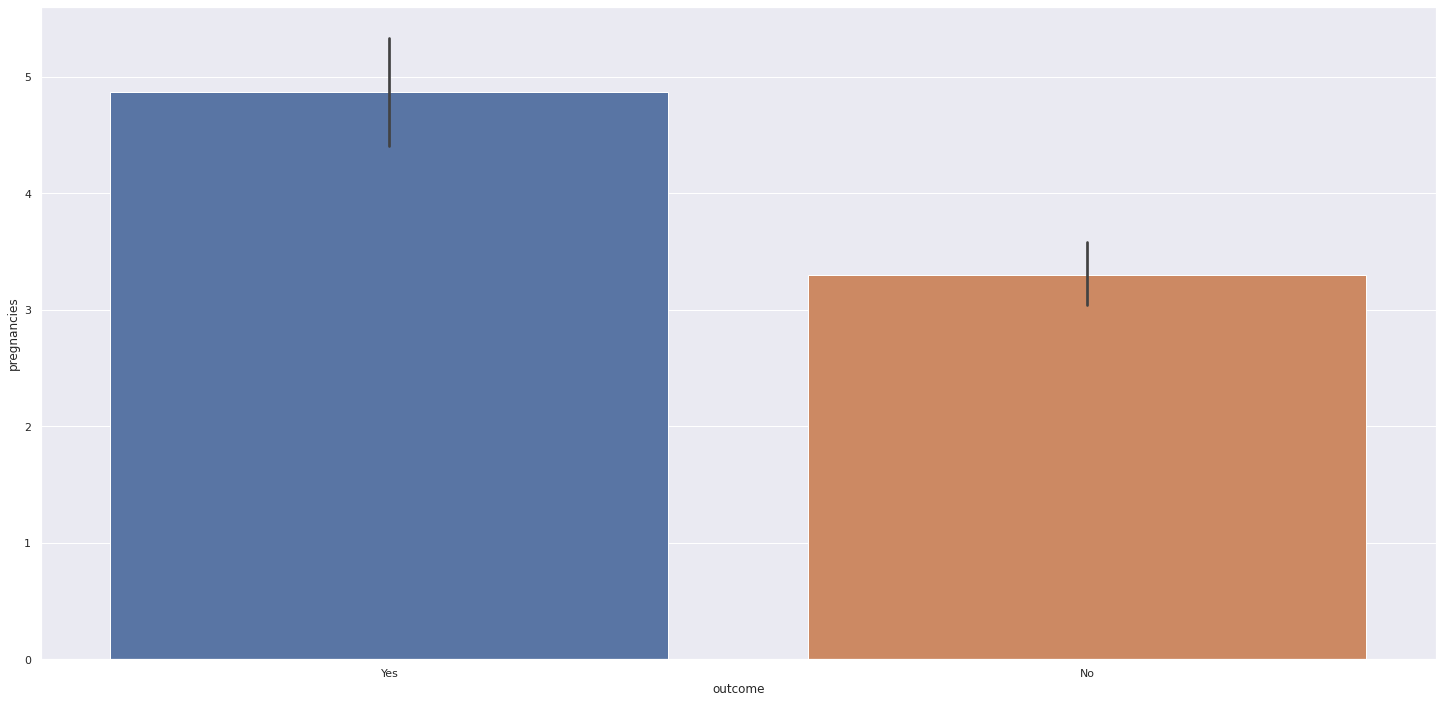

In [115]:
sns.barplot(y='pregnancies', x='outcome', data=df4);

### H5 Obese and over weight people are more likely to be diabetic.
**FALSE** There's more no-diabetic people in each weight status.

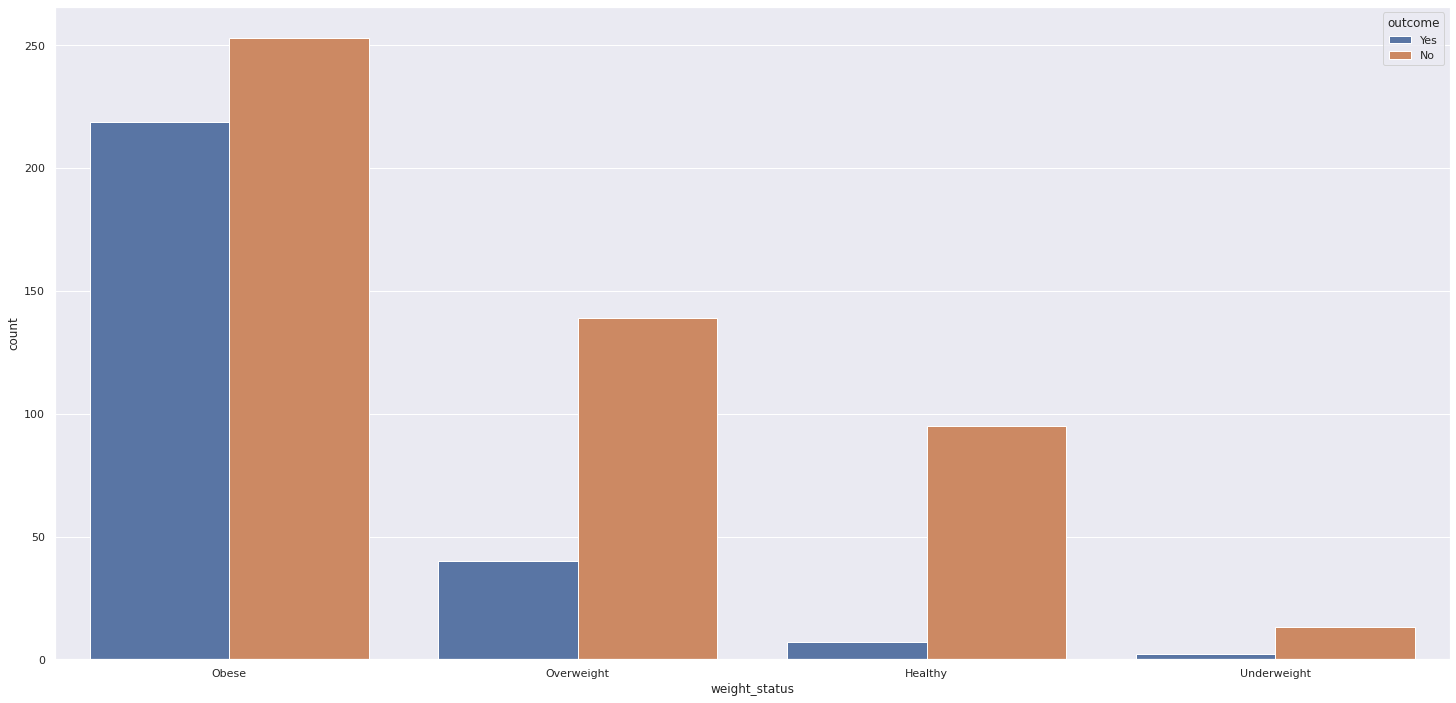

In [116]:
sns.countplot(hue='outcome', x='weight_status', data=df4);

### H6 Non-smoking people are less likely to be diabetic.
**INCONCLUSIVE** There's no smiking data.

### H7 Peaple with high insuline more likely to be non-diabetic.
**FALSE** People with high insuline is more likely to be diabetic.

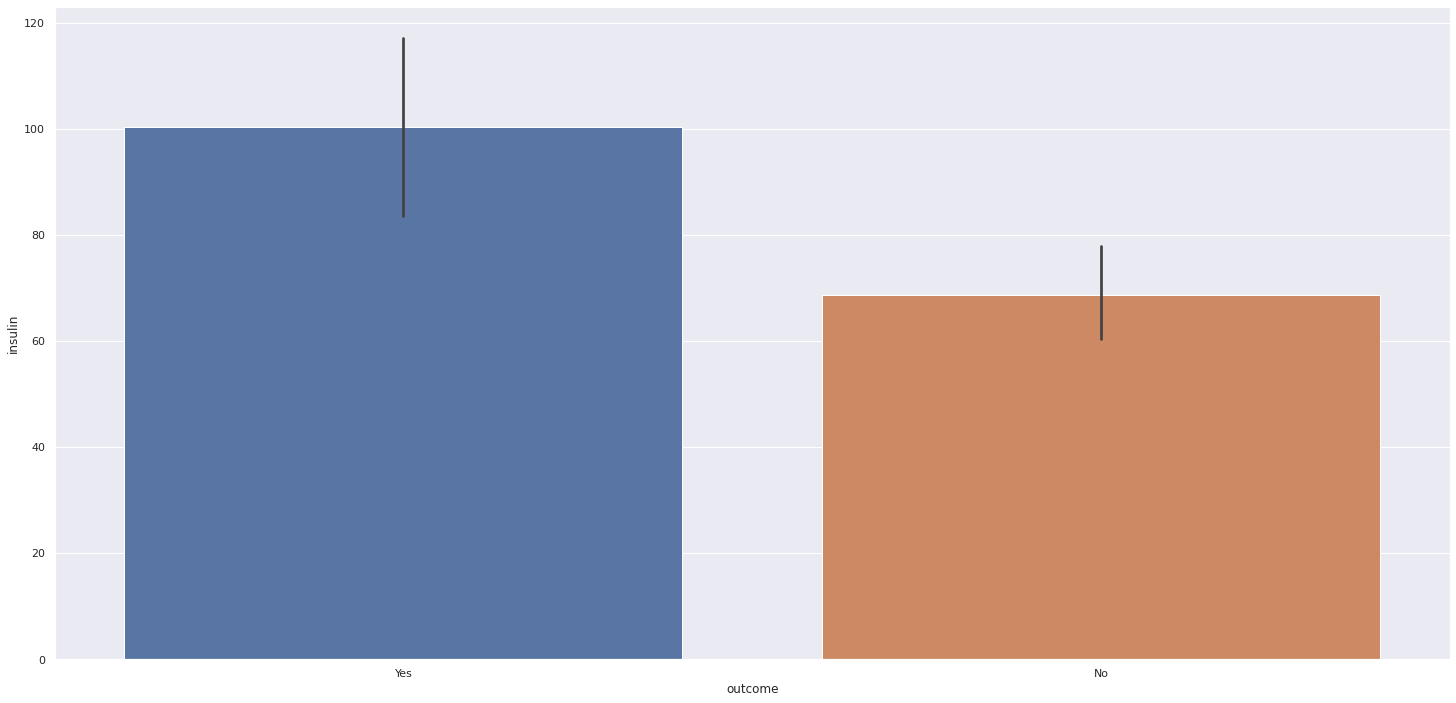

In [117]:
sns.barplot(x='outcome', y='insulin', data=df4);

### H8 Peaple with high glucose more likely to be diabetic.
**TRUE** People with high insuline is more lokely to be diabetic.

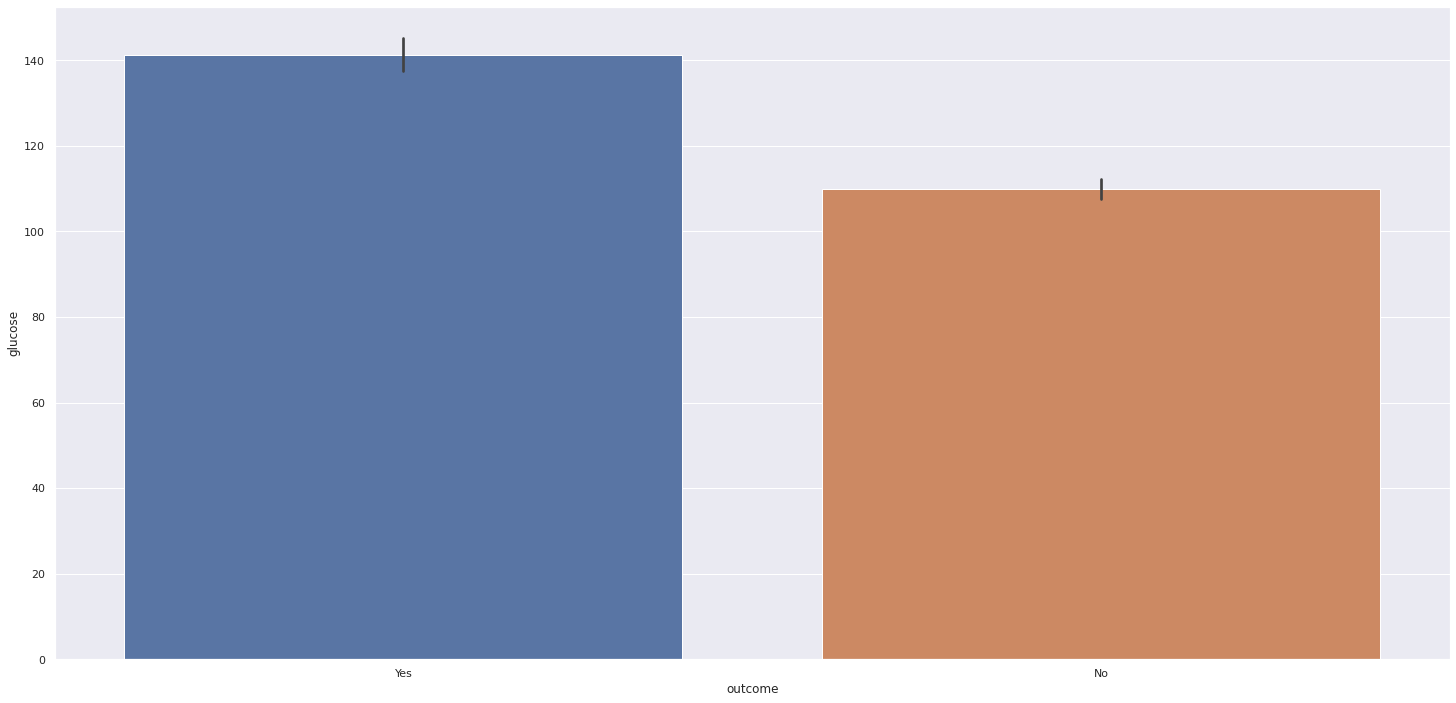

In [118]:
sns.barplot(y='glucose', x='outcome', data=df4);

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

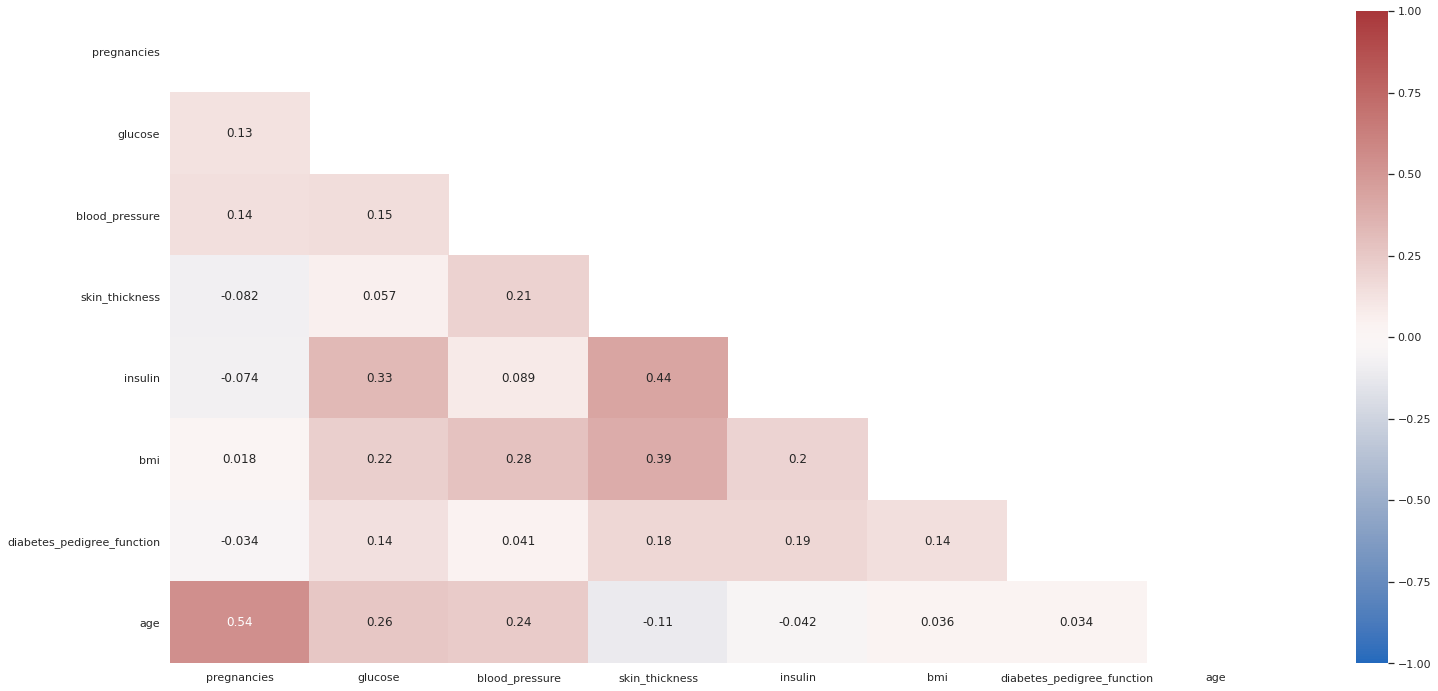

In [119]:
corr = num_attr.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    sns.heatmap(corr, annot=True, vmax=1, center=0, vmin=-1, cmap='vlag', mask=mask);

### 4.3.2 Categorical Correlation

In [120]:
a1 = cramer_v(cat_attr['outcome'], cat_attr['outcome'])
a2 = cramer_v(cat_attr['outcome'], cat_attr['life_stage'])
a3 = cramer_v(cat_attr['outcome'], cat_attr['weight_status'])

a4 = cramer_v(cat_attr['life_stage'], cat_attr['outcome'])
a5 = cramer_v(cat_attr['life_stage'], cat_attr['life_stage'])
a6 = cramer_v(cat_attr['life_stage'], cat_attr['weight_status'])

a7 = cramer_v(cat_attr['weight_status'], cat_attr['outcome'])
a8 = cramer_v(cat_attr['weight_status'], cat_attr['life_stage'])
a9 = cramer_v(cat_attr['weight_status'], cat_attr['weight_status'])

d = pd.DataFrame({'outcome': [a1, a2, a3], 
                  'life_stage': [a4, a5, a6],
                  'weight_status': [a7, a8, a9]}, 
                 index=['outcome', 'life_stage', 'weight_status'])

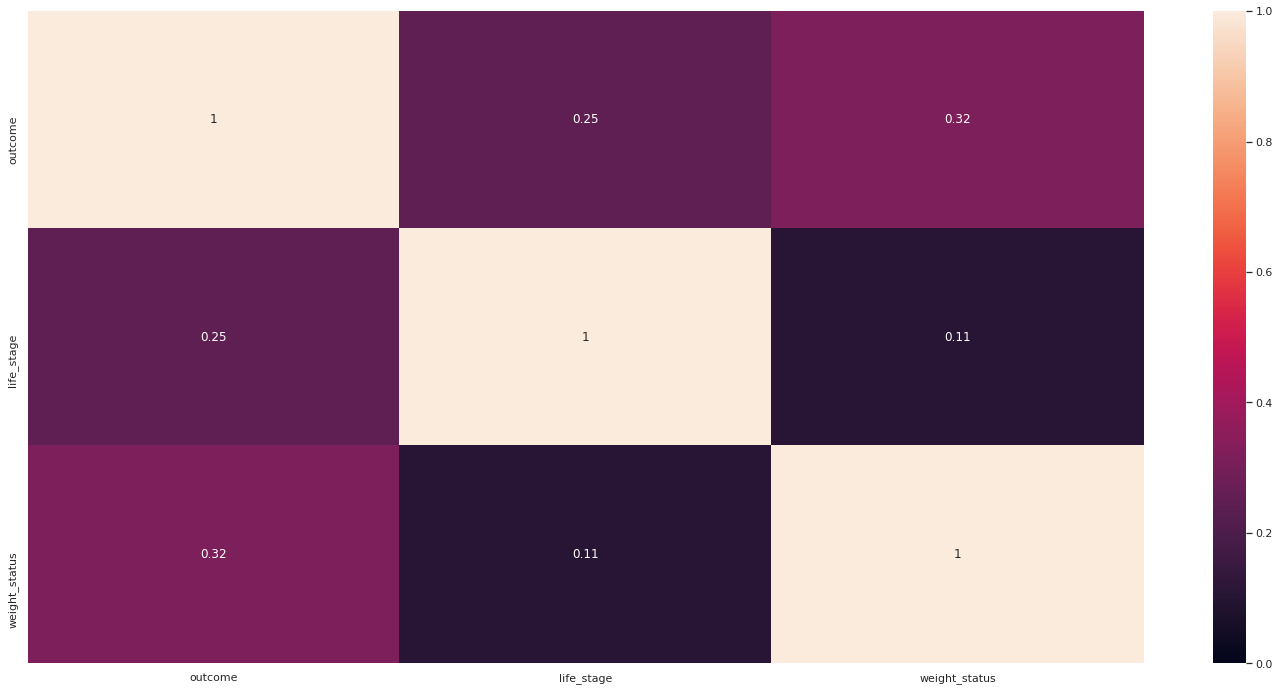

In [121]:
sns.heatmap(d, annot=True, vmin=0, vmax=1);

# 5.0 Data Preparation

In [122]:
X = df4.drop(columns=['outcome'])
y = df4.outcome

## 5.1 Spliting into Test and Train

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## 5.2 Rescaling

In [124]:
rb = RobustScaler()

In [125]:
num_columns = X.select_dtypes(exclude='object').columns

X_rescaled = X.copy()
X_train_rescaled = X_train.copy()
X_test_rescaled = X_test.copy()

In [126]:
X_rescaled[num_columns] = rb.fit_transform(X[num_columns])
X_train_rescaled[num_columns] = rb.fit_transform(X_train[num_columns])
X_test_rescaled[num_columns] = rb.fit_transform(X_test[num_columns])

## 5.3 Encoding

In [127]:
X_rescaled['life_stage'] = X_rescaled['life_stage'].map({'Early Adulthood': 0, 'Midlife': 1, 'Mature Adulthood': 2, 'Late Adulthood': 3})
X_train_rescaled['life_stage'] = X_train_rescaled['life_stage'].map({'Early Adulthood': 0, 'Midlife': 1, 'Mature Adulthood': 2, 'Late Adulthood': 3})
X_test_rescaled['life_stage'] = X_test_rescaled['life_stage'].map({'Early Adulthood': 0, 'Midlife': 1, 'Mature Adulthood': 2, 'Late Adulthood': 3})

In [128]:
X_rescaled['weight_status'] = X_rescaled['weight_status'].map({'Underweight': 0, 'Healthy': 1, 'Overweight': 2, 'Obese': 3})
X_train_rescaled['weight_status'] = X_train_rescaled['weight_status'].map({'Underweight': 0, 'Healthy': 1, 'Overweight': 2, 'Obese': 3})
X_test_rescaled['weight_status'] = X_test_rescaled['weight_status'].map({'Underweight': 0, 'Healthy': 1, 'Overweight': 2, 'Obese': 3})

In [129]:
y = y.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})
y_train = y_train.map({'No': 0, 'Yes': 1})

# 6.0 Feature Selection

## 6.1 Boruta as Feature Selector

In [130]:
# X_train_n = X_train_rescaled.values
# y_train_n = y_train.values.ravel()

In [131]:
# rf = RandomForestClassifier()

# boruta = BorutaPy(rf, verbose=2)
# boruta.fit(X_train_n, y_train_n)

### 6.1.1 Best Features

In [132]:
# cols_selected = boruta.support_.tolist()
# cols_selected

In [133]:
cols_selected = [True, True, False, False, False, True, True, True, False, False]

best_cols = X_train.columns[cols_selected].tolist()
best_cols

['pregnancies', 'glucose', 'bmi', 'diabetes_pedigree_function', 'age']

## 6.2 Manual Feature Selection

This step can be used to add some features we think can improve the model accuracy. But I decided that I'll not imput any column.

# 7.0 Machine Learning Modeling

## 7.1 Dummy Model

In [134]:
dummy = DummyClassifier()
dummy.fit(X_train_rescaled[best_cols], y_train)

y_pred = dummy.predict(X_test_rescaled[best_cols])

/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [135]:
dummy_resul = ml_error('Dummy', y_test, y_pred)
dummy_resul

,Accuracy,Precision,Recall,F1
Dummy,0.583333,0.415584,0.477612,0.444444


### 7.1.2 Cross Validation

In [136]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), RobustScaler(), X_rescaled[best_cols], y)
dummy_cv

/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/home/junior/.pyenv/versions/anaconda3-2020.02/envs/ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("T

,Accuracy,Precision,Recall,F1
Dummy,0.534 +/- 0.038,0.489 +- 0.05,0.489 +- 0.049,0.488 +- 0.049


## 7.2 Logistic Regression

In [137]:
lg = LogisticRegression()
lg.fit(X_train_rescaled[best_cols], y_train)

y_pred = lg.predict(X_test_rescaled[best_cols])

In [138]:
lg_resul = ml_error('Logistic Regression', y_test, y_pred)
lg_resul

,Accuracy,Precision,Recall,F1
Logistic Regression,0.723958,0.625,0.522388,0.569106


### 7.2.1 Cross Validation

In [139]:
lg_cv = ml_cv_results('Logistic Regression', LogisticRegression(), RobustScaler(), X_rescaled[best_cols], y)
lg_cv

,Accuracy,Precision,Recall,F1
Logistic Regression,0.767 +/- 0.024,0.751 +- 0.024,0.722 +- 0.03,0.729 +- 0.028


## 7.3 K Neighbors Classifier

In [140]:
knn = KNeighborsClassifier()
knn.fit(X_train_rescaled[best_cols], y_train)

y_pred = knn.predict(X_test_rescaled[best_cols])

In [141]:
knn_resul = ml_error('K Neighbors Classifier', y_test, y_pred)
knn_resul

,Accuracy,Precision,Recall,F1
K Neighbors Classifier,0.744792,0.655172,0.567164,0.608


### 7.3.1 Cross Validation

In [142]:
knn_cv = ml_cv_results('K Neighboors Classifier', KNeighborsClassifier(), RobustScaler(), X_rescaled[best_cols], y)
knn_cv

,Accuracy,Precision,Recall,F1
K Neighboors Classifier,0.751 +/- 0.024,0.73 +- 0.024,0.727 +- 0.035,0.723 +- 0.025


## 7.4  Random Forest

In [143]:
rf = RandomForestClassifier()
rf.fit(X_train_rescaled[best_cols], y_train)

y_pred = rf.predict(X_test_rescaled[best_cols])

In [144]:
rf_resul = ml_error('Random Forest', y_test, y_pred)
rf_resul

,Accuracy,Precision,Recall,F1
Random Forest,0.760417,0.661538,0.641791,0.651515


### 7.4.1 Cross Validation

In [145]:
rf_cv = ml_cv_results('Random Forest', RandomForestClassifier(), RobustScaler(), X_rescaled[best_cols], y)
rf_cv

,Accuracy,Precision,Recall,F1
Random Forest,0.773 +/- 0.032,0.755 +- 0.023,0.741 +- 0.039,0.743 +- 0.031


## 7.5 XGBoost

In [146]:
xgb = XGBClassifier()
xgb.fit(X_train_rescaled[best_cols], y_train)

y_pred = xgb.predict(X_test_rescaled[best_cols])

In [147]:
xgb_resul = ml_error('XGBoost', y_test, y_pred)
xgb_resul

,Accuracy,Precision,Recall,F1
XGBoost,0.744792,0.628571,0.656716,0.642336


### 7.5.1 Cross Validation

In [148]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(), RobustScaler(), X_rescaled[best_cols], y)
xgb_cv

,Accuracy,Precision,Recall,F1
XGBoost,0.755 +/- 0.016,0.731 +- 0.017,0.724 +- 0.02,0.726 +- 0.018


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [149]:
modeling_resul = pd.concat([dummy_resul, lg_resul, knn_resul, rf_resul, xgb_resul])
modeling_resul

,Accuracy,Precision,Recall,F1
Dummy,0.583333,0.415584,0.477612,0.444444
Logistic Regression,0.723958,0.625000,0.522388,0.569106
K Neighbors Classifier,0.744792,0.655172,0.567164,0.608000
Random Forest,0.760417,0.661538,0.641791,0.651515
XGBoost,0.744792,0.628571,0.656716,0.642336


### 7.6.2 Real Performance - Cross Validation

In [150]:
modeling_resul_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, xgb_cv])
modeling_resul_cv

,Accuracy,Precision,Recall,F1
Dummy,0.534 +/- 0.038,0.489 +- 0.05,0.489 +- 0.049,0.488 +- 0.049
Logistic Regression,0.767 +/- 0.024,0.751 +- 0.024,0.722 +- 0.03,0.729 +- 0.028
K Neighboors Classifier,0.751 +/- 0.024,0.73 +- 0.024,0.727 +- 0.035,0.723 +- 0.025
Random Forest,0.773 +/- 0.032,0.755 +- 0.023,0.741 +- 0.039,0.743 +- 0.031
XGBoost,0.755 +/- 0.016,0.731 +- 0.017,0.724 +- 0.02,0.726 +- 0.018


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [164]:
# params = {
#     'n_estimators': [100, 500, 1000, 2000, 3000],
#     'criterion': ['gini', 'entropy'],
#     'max_features': ['auto', 'log2', None]
# }

# rscv = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=params,
#                          n_iter=30, return_train_score=True, cv=5, scoring=f1)

In [171]:
# rscv.fit(X_rescaled[best_cols], y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'log2', None],
                                        'n_estimators': [100, 500, 1000, 2000,
                                                         3000]},
                   return_train_score=True, scoring=make_scorer(<lambda>))

In [172]:
# rscv.best_score_

0.7290337351298722

In [173]:
# rscv.best_params_

{'n_estimators': 100, 'max_features': 'log2', 'criterion': 'entropy'}

## 8.2 Final Model

In [175]:
best_params = {'n_estimators': 100, 'max_features': 'log2', 'criterion': 'entropy'}
rf_best = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                max_features=best_params['max_features'],
                                criterion=best_params['criterion'])

In [177]:
rf_best_cv = ml_cv_results('Random Forest', RandomForestClassifier(), RobustScaler(), X[best_cols], y)
rf_best_cv

,Accuracy,Precision,Recall,F1
Random Forest,0.764 +/- 0.024,0.744 +- 0.037,0.723 +- 0.035,0.729 +- 0.035


The best metrics are from default Random FOrest Classifier. Therefore I'll use them to create the model and deploy the model.

# 9.0 Traduction and Error's Interpretation

## 9.1 Machine Learning Performance

In [179]:
rf = RandomForestClassifier()
rf.fit(X_train_rescaled[best_cols], y_train)

y_pred = rf.predict(X_test_rescaled[best_cols])

In [185]:
ml_error('Random Forest', y_test, y_pred)

,Accuracy,Precision,Recall,F1
Random Forest,0.755208,0.65625,0.626866,0.641221


In [186]:
ml_cv_results('Random Forest', RandomForestClassifier(), RobustScaler(), X_rescaled[best_cols], y)

,Accuracy,Precision,Recall,F1
Random Forest,0.771 +/- 0.016,0.751 +- 0.014,0.73 +- 0.019,0.737 +- 0.018


## 9.2 Business Performance

In [187]:
aux1 = pd.DataFrame(data={
        "Value": [0.771, 0.751, 0.730], 
        "Best Scenario": [0.771 + 0.016, 0.751 + 0.014, 0.730 + 0.019],
        "Worst Scenario": [0.771 - 0.016, 0.751 - 0.014, 0.730 - 0.019]
}, 
    index=["Accuracy", "Precision", "Recall"])

aux1

,Value,Best Scenario,Worst Scenario
Accuracy,0.771,0.787,0.755
Precision,0.751,0.765,0.737
Recall,0.730,0.749,0.711


# 10.0 Model Deploy

In [188]:
final_model = RandomForestClassifier()
final_model.fit(X_rescaled[best_cols], y)

RandomForestClassifier()

In [190]:
joblib.dump(final_model, '../models/randomforest_cycle1.joblib')

['../models/randomforest_cycle1.joblib']

In [191]:
rb = RobustScaler()
joblib.dump(rb, '../parameters/robustscaler_cycle1.joblib')

['../parameters/robustscaler_cycle1.joblib']

## 10.1 Diabetes Class

In [ ]:
import joblib
import pandas as pd
import 